In [1]:
import fiasco
from fiasco.io import DataIndexer
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.visualization import quantity_support, ImageNormalize, LogStretch

from mocksipipeline.util import read_cube_with_xarray

## Continuum Contributions

I just want to see how the continuum contribution varies as a function of wavelength and abundance file

In [4]:
all_ion_names = fiasco.list_ions()
temperature = 10**np.arange(5,8,0.01) * u.K
wavelength = np.arange(1,100,0.055) * u.AA
all_ions_coronal = fiasco.IonCollection(
    *[fiasco.Ion(i, temperature, abundance='sun_coronal_1992_feldman_ext') for i in all_ion_names]
)
all_ions_photospheric = fiasco.IonCollection(
    *[fiasco.Ion(i, temperature, abundance='sun_photospheric_2015_scott') for i in all_ion_names]
)

In [12]:
ff_coronal = all_ions_coronal.free_free(wavelength)
ff_photospheric = all_ions_photospheric.free_free(wavelength)

In [13]:
fb_coronal = all_ions_coronal.free_bound(wavelength)
fb_photospheric = all_ions_photospheric.free_bound(wavelength)

2024-10-01 10:11:50 - fiasco - WARNING: H 2 not included in free-bound emission. _fblvl dataset missing for H 2.
2024-10-01 10:11:50 - fiasco - WARNING: He 3 not included in free-bound emission. _fblvl dataset missing for He 3.
2024-10-01 10:11:50 - fiasco - WARNING: Li 1 not included in free-bound emission. _fblvl dataset missing for Li 1.
2024-10-01 10:11:50 - fiasco - WARNING: Li 2 not included in free-bound emission. _fblvl dataset missing for Li 2.
2024-10-01 10:11:50 - fiasco - WARNING: Li 3 not included in free-bound emission. _fblvl dataset missing for Li 3.
2024-10-01 10:11:50 - fiasco - WARNING: Li 4 not included in free-bound emission. _fblvl dataset missing for Li 4.
2024-10-01 10:11:50 - fiasco - WARNING: Be 1 not included in free-bound emission. _fblvl dataset missing for Be 1.
2024-10-01 10:11:50 - fiasco - WARNING: Be 2 not included in free-bound emission. _fblvl dataset missing for Be 2.
2024-10-01 10:11:50 - fiasco - WARNING: Be 3 not included in free-bound emission. 

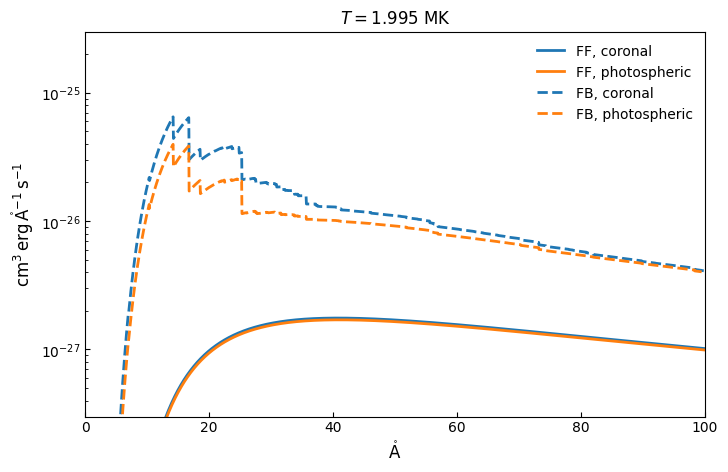

In [29]:
with quantity_support():
    t_idx = np.argmin(np.fabs(temperature - 2*u.MK))
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot()
    ax.plot(wavelength, ff_coronal[t_idx,:], ls='-', color='C0',label='FF, coronal')
    ax.plot(wavelength, ff_photospheric[t_idx,:], ls='-', color='C1', label='FF, photospheric')
    ax.plot(wavelength, fb_coronal[t_idx,:], ls='--', color='C0', label='FB, coronal')
    ax.plot(wavelength, fb_photospheric[t_idx,:], ls='--', color='C1', label='FB, photospheric')
    ax.set_xlim(0,100)
    ax.set_ylim(3e-28, 3e-25)
    ax.set_yscale('log')
    ax.set_title(f'$T=${temperature[t_idx].to("MK"):.03f}')
    ax.legend()
    fig.savefig(f'rfa_figures/continuum-contribution-{t_idx}.png',dpi=300)

In [30]:
dem_coronal = read_cube_with_xarray(
    '/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/cdr/rfa/ar_1h_coronal/dem_cube.nc',
    'temperature',
    'phys.temperature'
)
dem_photospheric = read_cube_with_xarray(
    '/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/cdr/rfa/ar_1h_photospheric/dem_cube.nc',
    'temperature',
    'phys.temperature'
)

In [32]:
cutout = np.s_[:,185:195,175:185]
coronal_dem_cutout = dem_coronal[cutout]
coronal_dem_avg = coronal_dem_cutout.rebin((1,)+coronal_dem_cutout.data.shape[1:],
                                           operation=np.mean)[:,0,0]
photospheric_dem_cutout = dem_photospheric[cutout]
photospheric_dem_avg = photospheric_dem_cutout.rebin((1,)+photospheric_dem_cutout.data.shape[1:],
                                                     operation=np.mean)[:,0,0]

(1e+25, 5e+27)

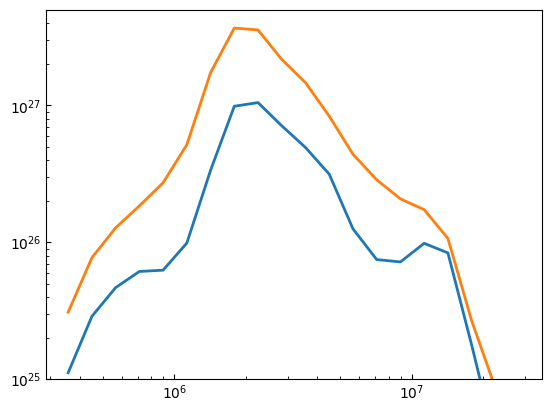

In [33]:
plt.plot(coronal_dem_avg.axis_world_coords(0)[0], coronal_dem_avg.data)
plt.plot(photospheric_dem_avg.axis_world_coords(0)[0], photospheric_dem_avg.data)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e25,5e27)

In [34]:
def sum_over_dem(temperature, continuum, dem):
    t_dem = dem.axis_world_coords(0)[0]
    f_interp = interp1d(temperature.value, continuum.value, axis=0, fill_value='extrapolate')
    continuum_interp = f_interp(t_dem.to_value(temperature.unit)) * continuum.unit
    return (continuum_interp * dem.data[:,np.newaxis] * dem.unit).sum(axis=0)

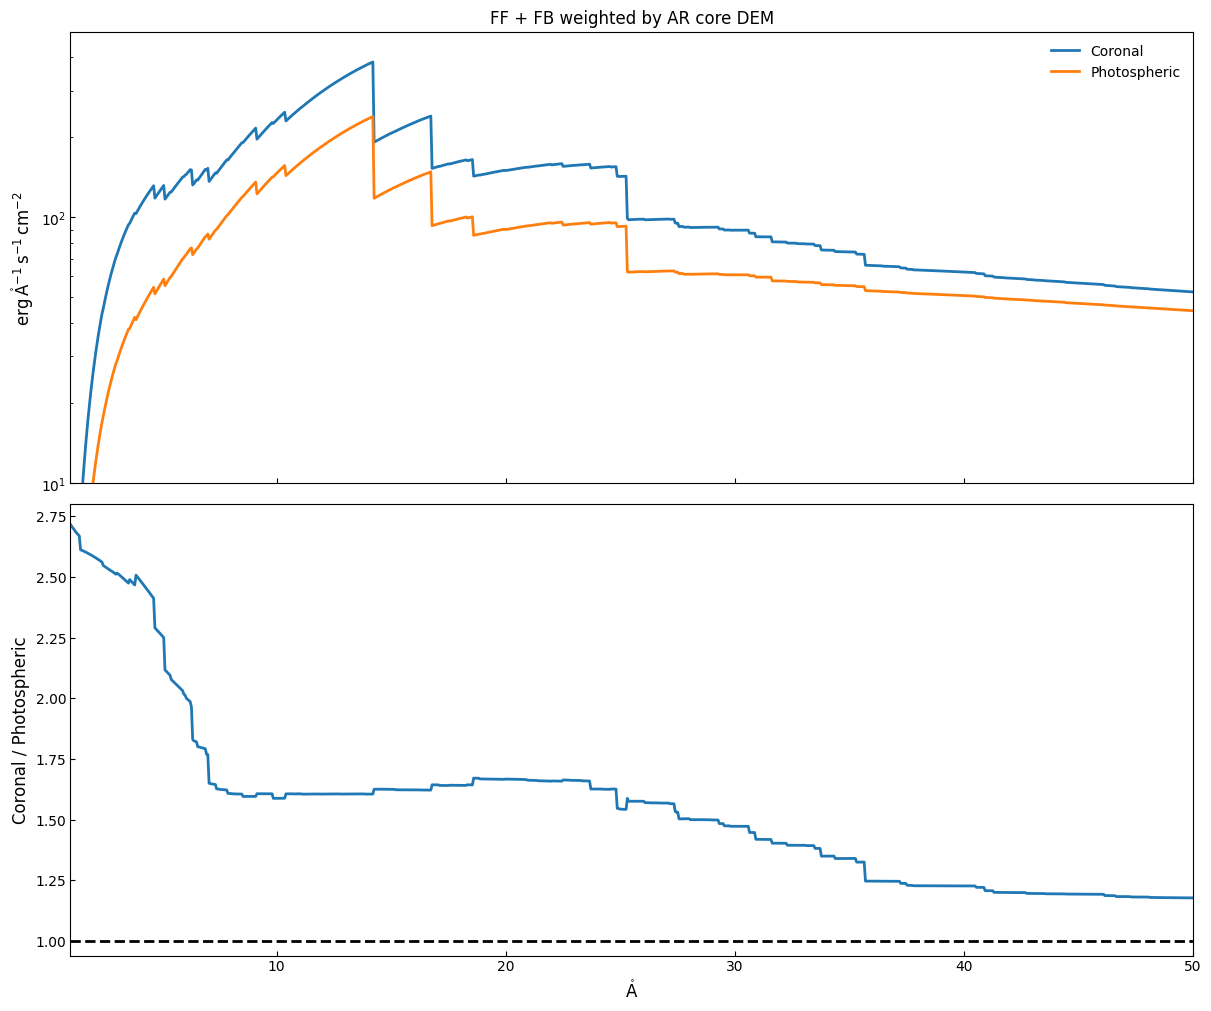

In [43]:
cont_coronal_int = sum_over_dem(temperature, ff_coronal+fb_coronal, coronal_dem_avg)
cont_photospheric_int = sum_over_dem(temperature, ff_photospheric+fb_photospheric, coronal_dem_avg)
fig = plt.figure(figsize=(12,10),layout='constrained')
with quantity_support():
    ax = fig.add_subplot(211)
    ax.plot(wavelength, cont_coronal_int, label='Coronal')
    ax.plot(wavelength, cont_photospheric_int, label='Photospheric')
    ax.set_xlim(1,50)
    ax.set_ylim(10, 5e2)
    ax.set_yscale('log')
    ax.set_title('FF + FB weighted by AR core DEM')
    ax.legend()
    ax.label_outer()
    ax = fig.add_subplot(212,sharex=ax)
    ax.plot(wavelength, cont_coronal_int/cont_photospheric_int)
    ax.axhline(y=1,ls='--', color='k')
    ax.set_ylabel('Coronal / Photospheric')
    #plt.xlim(0,25)

CHIANTI Database Ion
---------------------
Name: H 2
Element: hydrogen (1)
Charge: +1
Number of Levels: 0
Number of Transitions: 0

Temperature range: [0.100 MK, 97.724 MK]

HDF5 Database: /Users/wtbarnes/Documents/projects/chianti/database/CHIANTI_v8.0.7/dbase.h5
Using Datasets:
  ioneq: chianti
  abundance: sun_coronal_1992_feldman_ext
  ip: chianti


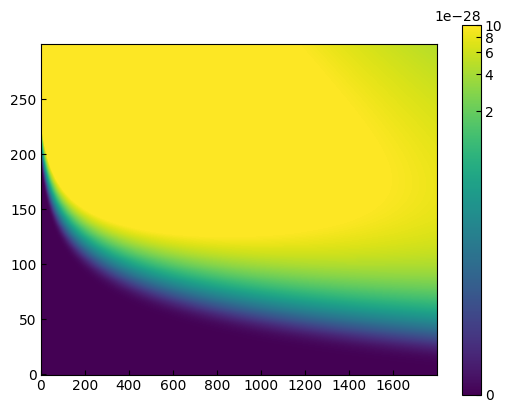

In [161]:
i_ion = 1
print(all_ions_coronal[i_ion])
ff_el = all_ions_coronal[i_ion].free_free(wavelength)*all_ions_coronal[i_ion].ioneq[:,np.newaxis]*all_ions_coronal[i_ion].abundance
plt.imshow(ff_el.value,norm=ImageNormalize(vmin=0, vmax=1e-27, stretch=LogStretch()), aspect=5, origin='lower')
plt.colorbar()